In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *
from utils.plots import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

In [3]:
# Set parameters
estimatorType='kalman' # kalman or rnn
seeAction=True
seeMeasurement=True
seeEstimate=False
seeTime=False
T=12

In [4]:
if estimatorType=='rnn':
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=500
    T_trainRNN=T
    generatorType='random01'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=0.2)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)

    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    history=model.fit(x=measurements_corrupted_trainRNN,y=objectives_trainRNN,batch_size=1,epochs=20,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
print('Done')

Done


In [5]:
if estimatorType=='rnn':
    idx_sample=2
    estimates_trainRNN=model.predict(measurements_corrupted_trainRNN)
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

Done


In [6]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()
print()

# contruct rewarder
rewarder=ThresholdRewarder(threshold=2, cost=50, windowSize=4)
rewarder.summarize()

Kalman estimator
  observationsDimensions: [(5,), (5, 1)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False
  seeCovariance= False

Threshold rewarder
  window size: 4
  threshold: 2
  cost: 50
  number of measures in the window: 0


In [7]:
# generate sequences for training and validating the agent
numberSamples_train=100
T_train=T

numberSamples_valid=numberSamples_train
T_valid=T_train

(objectives_train,measurements_train)=estimator.generateSequence(T_train,numberSamples=numberSamples_train)
(objectives_valid,measurements_valid)=estimator.generateSequence(T_valid,numberSamples=numberSamples_valid)

print('shape training objectives:',np.shape(objectives_train))
print('shape training measurements:',np.shape(measurements_train))
print('shape validating objectives:',np.shape(objectives_valid))
print('shape validating measurements:',np.shape(measurements_valid))

shape training objectives: (100, 12, 1)
shape training measurements: (100, 12, 1)
shape validating objectives: (100, 12, 1)
shape validating measurements: (100, 12, 1)


In [8]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_train,measurements_train,objectives_valid,measurements_valid)
print('Agent constructed')

Environment parameters
  inputDimensions= [(5,), (5, 1)]
Sequences parameters
  outOfRangeValue= -1
  n_dim_obj= 1
  n_dim_meas= 1
  numberSamples_train 100
  numberSamples_valid 100
Kalman estimator
  observationsDimensions: [(5,), (5, 1)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False
  seeCovariance= False
Threshold rewarder
  window size: 4
  threshold: 2
  cost: 50
  number of measures in the window: 0
Agent constructed


In [10]:
# Train agent
agent.resumeTrainingMode() # not required
agent.run(n_epochs=10, epoch_length=numberSamples_train*T_train)
cumulatedRewards_valid=agent._controllers[2].rewards
print('Agent Trained')

Average (on the epoch) training loss: 45.21741922697236
Episode average V value: -109.64645608266194
Average (on the epoch) training loss: 44.9708950601275
Episode average V value: -96.38965479532878
Average (on the epoch) training loss: 46.76364176409507
Episode average V value: -96.1124496459961
Average (on the epoch) training loss: 48.11467144331444
Episode average V value: -69.84103393554688
Average (on the epoch) training loss: 47.060652355044695
Episode average V value: -60.170818567276
Average (on the epoch) training loss: 46.532746264409774
Episode average V value: -76.28612963358562
Average (on the epoch) training loss: 45.78287752000346
Episode average V value: -57.1176872253418
Average (on the epoch) training loss: 44.58617283740318
Episode average V value: -90.83429916699727
Average (on the epoch) training loss: 46.308360109488454
Episode average V value: -103.51495361328125
Average (on the epoch) training loss: 45.51385737086769
Episode average V value: -159.0793660481771


Average (on the epoch) training loss: 47.31535002344322
Episode average V value: -101.37886015574138
Average (on the epoch) training loss: 47.230958114060854
Episode average V value: -106.8541488647461
Average (on the epoch) training loss: 47.231350190255625
Episode average V value: -142.31866455078125
Average (on the epoch) training loss: 47.290100242390096
Episode average V value: -117.51017761230469
Average (on the epoch) training loss: 47.26495425280437
Episode average V value: -118.21050238609314
Average (on the epoch) training loss: 47.224332868597685
Episode average V value: -94.97857666015625
Average (on the epoch) training loss: 47.44984925494662
Episode average V value: -101.77693605422974
Average (on the epoch) training loss: 47.49760816151328
Episode average V value: -105.674209912618
Average (on the epoch) training loss: 47.54489457925026
Episode average V value: -171.14599609375
Average (on the epoch) training loss: 47.51918956452958
Episode average V value: -132.05556790

Average (on the epoch) training loss: 47.66401849561723
Episode average V value: -98.25720977783203
Average (on the epoch) training loss: 47.53636477258627
Episode average V value: -148.84727160135904
Average (on the epoch) training loss: 47.425785941773874
Episode average V value: -134.2927703857422
Average (on the epoch) training loss: 47.54765250706672
Episode average V value: -77.35723594824474
Average (on the epoch) training loss: 47.53764228334705
Episode average V value: -113.2449951171875
Average (on the epoch) training loss: 47.45667400449041
Episode average V value: -151.21620178222656
Average (on the epoch) training loss: 47.41239684173598
Episode average V value: -184.75396728515625
Average (on the epoch) training loss: 47.31067963145397
Episode average V value: -89.10554536183675
Average (on the epoch) training loss: 47.210180433481995
Episode average V value: -106.37465373675029
Average (on the epoch) training loss: 47.335125369710575
Episode average V value: -89.34594122

Average (on the epoch) training loss: 48.76652968457807
Episode average V value: -91.84140745798747
Average (on the epoch) training loss: 48.86413847393956
Episode average V value: -75.6039667526881
Average (on the epoch) training loss: 48.85027825120288
Episode average V value: -64.0137406984965
Average (on the epoch) training loss: 49.165053730705694
Episode average V value: -159.02561362584433
Average (on the epoch) training loss: 49.02519775912316
Episode average V value: -74.5203119913737
Average (on the epoch) training loss: 48.81176795257309
Episode average V value: -102.81018010052767
Average (on the epoch) training loss: 48.70008112703568
Episode average V value: -105.41051816940308
Average (on the epoch) training loss: 48.80155608925263
Episode average V value: -71.4435088634491
Average (on the epoch) training loss: 48.881261423599646
Episode average V value: -104.07868830362956
Average (on the epoch) training loss: 48.89662415236015
Episode average V value: -135.608192125956

Average (on the epoch) training loss: 47.53418365659297
Episode average V value: -93.82746124267578
Average (on the epoch) training loss: 47.818325275714884
Episode average V value: -108.1681900024414
Average (on the epoch) training loss: 48.02095802200862
Episode average V value: -82.03986263275146
Average (on the epoch) training loss: 47.89045374671221
Episode average V value: -152.760329246521
Average (on the epoch) training loss: 48.15837984634106
Episode average V value: -170.9999542236328
Average (on the epoch) training loss: 48.179615504725675
Episode average V value: -106.13330078125
Average (on the epoch) training loss: 48.00564514226753
Episode average V value: -138.4892120361328
Average (on the epoch) training loss: 47.92741249248696
Episode average V value: -101.87895647684734
Average (on the epoch) training loss: 47.691909317655245
Episode average V value: -42.06658172607422
Average (on the epoch) training loss: 47.55905428274057
Episode average V value: -88.8735580444336


Average (on the epoch) training loss: 51.09637403009857
Episode average V value: -97.88839843056418
Average (on the epoch) training loss: 49.69110480619662
Episode average V value: -57.52912064393362
Average (on the epoch) training loss: 48.72072637987451
Episode average V value: -124.79422760009766
Average (on the epoch) training loss: 48.76790268433342
Episode average V value: -154.39815457661948
Average (on the epoch) training loss: 47.83225623035318
Episode average V value: -91.8036117553711
Average (on the epoch) training loss: 47.66735360769778
Episode average V value: -134.94677257537842
Average (on the epoch) training loss: 46.62765269883015
Episode average V value: -131.5581429799398
Average (on the epoch) training loss: 46.235110825678106
Episode average V value: -130.69558715820312
Average (on the epoch) training loss: 45.543162611674646
Episode average V value: -114.67940894762675
Average (on the epoch) training loss: 44.95453309191672
Episode average V value: -126.64489905

Average (on the epoch) training loss: 45.402070818510595
Episode average V value: -67.07023119926453
Average (on the epoch) training loss: 45.42737915515113
Episode average V value: -145.06100622812906
Average (on the epoch) training loss: 45.35501271083162
Episode average V value: -119.47771708170573
Average (on the epoch) training loss: 45.40613003767601
Episode average V value: -151.7592010498047
Average (on the epoch) training loss: 45.36542532660339
Episode average V value: -68.70312102635701
Average (on the epoch) training loss: 45.2964185852869
Episode average V value: -99.28143310546875
Average (on the epoch) training loss: 45.21405796280955
Episode average V value: -116.16638994216919
Average (on the epoch) training loss: 45.12884828704384
Episode average V value: -119.06112670898438
Average (on the epoch) training loss: 45.14775655321877
Episode average V value: -45.75620206197103
Average (on the epoch) training loss: 45.22540673657181
Episode average V value: -118.8502559661

Average (on the epoch) training loss: 45.991809736311225
Episode average V value: -182.69569396972656
Average (on the epoch) training loss: 46.052739453472206
Episode average V value: -150.261474609375
Average (on the epoch) training loss: 45.97650002378908
Episode average V value: -103.90174420674641
Average (on the epoch) training loss: 45.812702628549985
Episode average V value: -84.72725876172383
Average (on the epoch) training loss: 45.95380724831067
Episode average V value: -111.5985239202326
Average (on the epoch) training loss: 45.904447776925956
Episode average V value: -148.05734252929688
Average (on the epoch) training loss: 45.91007400200643
Episode average V value: -122.47095513343811
Average (on the epoch) training loss: 45.93672841256213
Episode average V value: -70.60008525848389
Average (on the epoch) training loss: 45.942897435921616
Episode average V value: -66.34184471766154
Average (on the epoch) training loss: 45.85933330078735
Episode average V value: -140.918828

Average (on the epoch) training loss: 44.10379008552907
Episode average V value: -82.77468967437744
Average (on the epoch) training loss: 44.36616766252348
Episode average V value: -141.69351196289062
Average (on the epoch) training loss: 44.24276941646494
Episode average V value: -154.09238942464194
Average (on the epoch) training loss: 44.15949075917879
Episode average V value: -129.07100518544516
Average (on the epoch) training loss: 44.25927269991515
Episode average V value: -97.06011422475179
Average (on the epoch) training loss: 44.4066159875903
Episode average V value: -71.64252503712972
Average (on the epoch) training loss: 44.25404279939418
Episode average V value: -67.86806869506836
Average (on the epoch) training loss: 44.203094291184485
Episode average V value: -125.1931811246005
Average (on the epoch) training loss: 44.30773442201361
Episode average V value: -79.79045009613037
Average (on the epoch) training loss: 44.36866162601362
Episode average V value: -161.83560180664

Average (on the epoch) training loss: 48.21120734354679
Episode average V value: -174.97955322265625
Average (on the epoch) training loss: 48.02649733735683
Episode average V value: -113.61878204345703
Average (on the epoch) training loss: 47.88946410795406
Episode average V value: -167.48582458496094
Average (on the epoch) training loss: 47.85748235705691
Episode average V value: -102.1884822845459
Average (on the epoch) training loss: 47.68802640269031
Episode average V value: -116.58811402320862
Average (on the epoch) training loss: 47.62325944284029
Episode average V value: -146.18724060058594
Average (on the epoch) training loss: 47.56197949397471
Episode average V value: -77.95443811416627
Average (on the epoch) training loss: 48.04631199207691
Episode average V value: -64.3701400756836
Average (on the epoch) training loss: 47.9353071586802
Episode average V value: -140.2078094482422
Average (on the epoch) training loss: 47.97286107104132
Episode average V value: -120.04704729715

Average (on the epoch) training loss: 46.94679650708851
Episode average V value: -104.27437591552734
Average (on the epoch) training loss: 47.004853516888915
Episode average V value: -113.75893084208171
Average (on the epoch) training loss: 46.88298861835022
Episode average V value: -99.05378723144531
Average (on the epoch) training loss: 47.368169769572376
Episode average V value: -124.03452769915263
Average (on the epoch) training loss: 47.522434435298806
Episode average V value: -72.39752705891927
Average (on the epoch) training loss: 47.147502145897946
Episode average V value: -77.27731323242188
Average (on the epoch) training loss: 46.795539900051715
Episode average V value: -100.98763275146484
Average (on the epoch) training loss: 46.812875020107185
Episode average V value: -99.16913604736328
Average (on the epoch) training loss: 47.3768055748827
Episode average V value: -116.38651275634766
Average (on the epoch) training loss: 47.30213268951412
Episode average V value: -150.8055

Average (on the epoch) training loss: 49.15459284734407
Episode average V value: -105.28187115987141
Average (on the epoch) training loss: 49.26442928338705
Episode average V value: -138.51499938964844
Average (on the epoch) training loss: 49.21280616832171
Episode average V value: -91.53501192728679
Average (on the epoch) training loss: 49.182270550516705
Episode average V value: -132.18118715286255
Average (on the epoch) training loss: 49.15728715853784
Episode average V value: -149.48451232910156
Average (on the epoch) training loss: 49.15806118002216
Episode average V value: -127.77774047851562
Testing score per episode (id: 0) is -581.3451510663422 (average over 100 episode(s))
Average (on the epoch) training loss: 59.0774237373405
Episode average V value: -141.67476099187678
Average (on the epoch) training loss: 50.6764013519275
Episode average V value: -136.50149536132812
Average (on the epoch) training loss: 47.71057987508671
Episode average V value: -74.5934100151062
Average (

Average (on the epoch) training loss: 48.479540500592535
Episode average V value: -115.27157592773438
Average (on the epoch) training loss: 48.42318182939911
Episode average V value: -156.46275329589844
Average (on the epoch) training loss: 48.67086242205717
Episode average V value: -96.51047420501709
Average (on the epoch) training loss: 48.71395842160448
Episode average V value: -114.1492805480957
Average (on the epoch) training loss: 49.15560315334245
Episode average V value: -180.80975898106894
Average (on the epoch) training loss: 49.027664768843
Episode average V value: -176.0708465576172
Average (on the epoch) training loss: 49.01602326464209
Episode average V value: -100.22142791748047
Average (on the epoch) training loss: 48.97392715776335
Episode average V value: -137.64437866210938
Average (on the epoch) training loss: 48.98313545613723
Episode average V value: -138.49729839960733
Average (on the epoch) training loss: 49.050976930159045
Episode average V value: -153.46690368

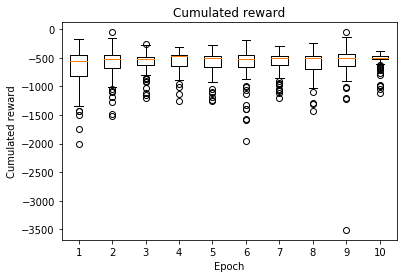

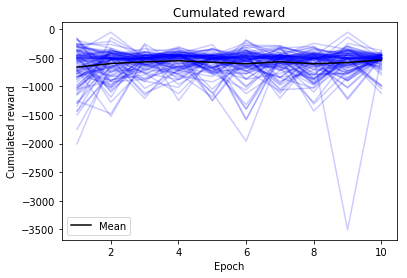

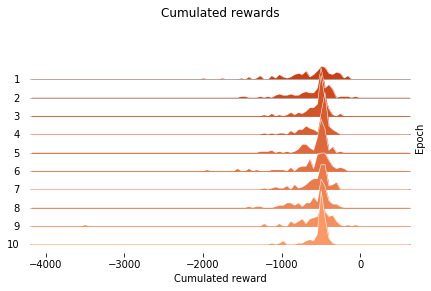

In [11]:
# plot validation
boxplotCumulatedRewards(cumulatedRewards_valid)
plotAllCumulatedRewards(cumulatedRewards_valid)
allHistoCumulatedRewards(cumulatedRewards_valid)

In [12]:
# generate test data
numberSamples_test=20
T_test=T
(objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)

# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

Test results computed


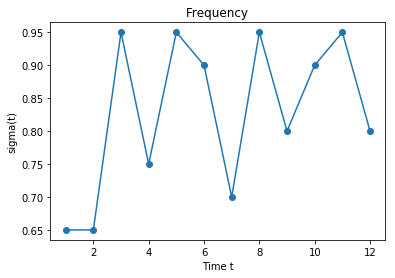

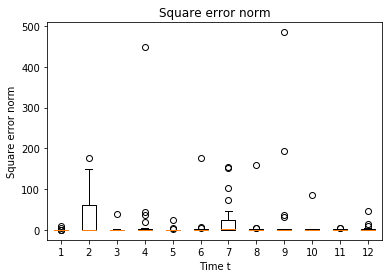

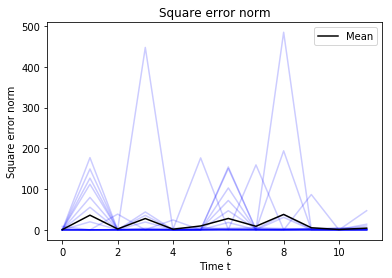

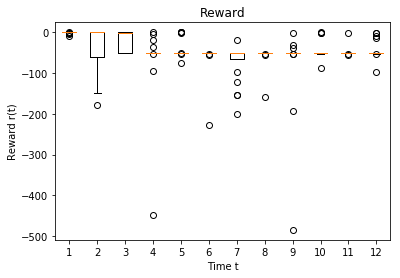

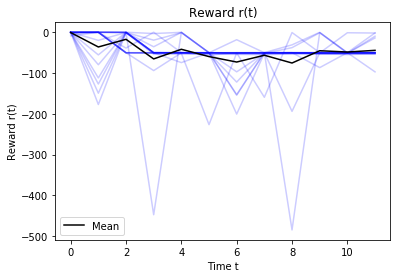

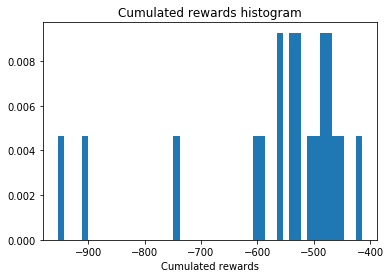

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1.,

In [13]:
# plot test
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_test)
boxplotErrors(objectives_test,estimates_test)
plotAllErrors(objectives_test,estimates_test)
boxplotRewards(rewards_test)
plotAllRewards(rewards_test)
histoCumulatedRewards(rewards_test)
sigmas_test

In [14]:
# regular run on test data
numberMeasurements=5

# compute regular sigma (with same dim than validation data)
sigmas_regular=regularSigma(T_valid,numberMeasurements,numberSamples=numberSamples_test)

(rewards_regular, estimates_regular)=agentForcedInference(agent, sigmas_regular)
print('Done.')

Done.


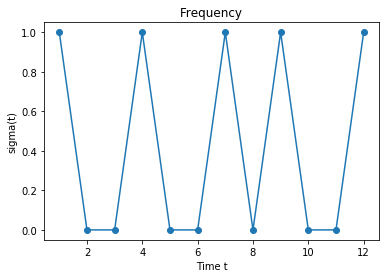

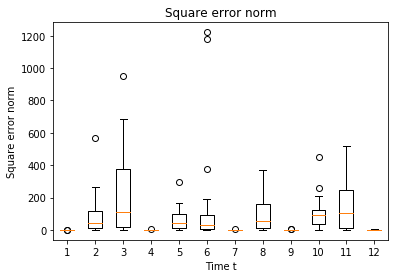

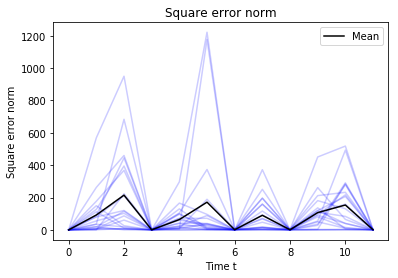

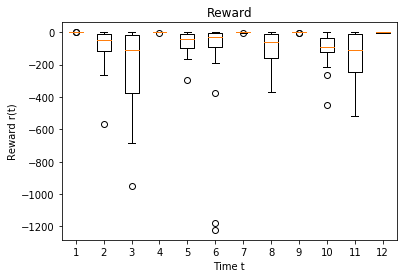

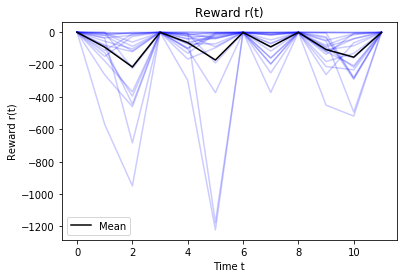

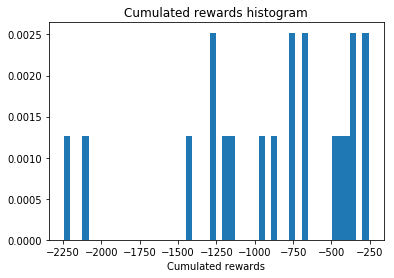

In [15]:
# plot test
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_regular)
boxplotErrors(objectives_test,estimates_regular)
plotAllErrors(objectives_test,estimates_regular)
boxplotRewards(rewards_regular)
plotAllRewards(rewards_regular)
histoCumulatedRewards(rewards_regular)

In [16]:
import importlib
import utils.agent_treatment
importlib.reload(utils.agent_treatment)
from utils.agent_treatment import *